In [1]:
import warnings
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

import re
import nltk
nltk.download('all')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()

warnings.filterwarnings("ignore")


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

In [4]:
import pandas as pd

data = pd.read_csv("Clothing reviews.csv", engine = 'python', nrows=1000000)
data.head(7)
print(data.shape)

data = data[data['Class Name'].isnull() == False]


(23486, 11)


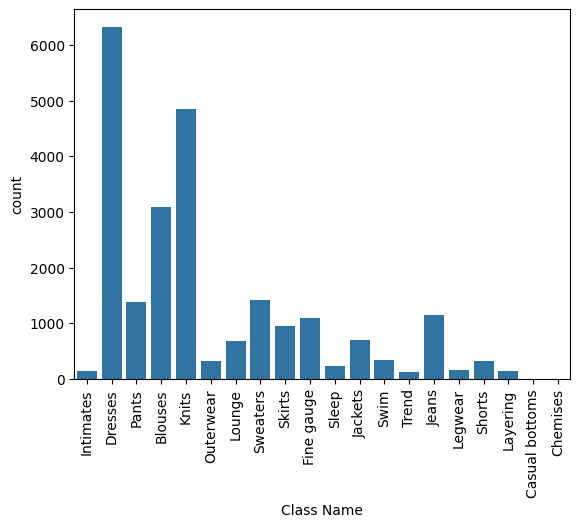

In [6]:
sns.countplot(data=data, x='Class Name')
plt.xticks(rotation=90)
plt.show()


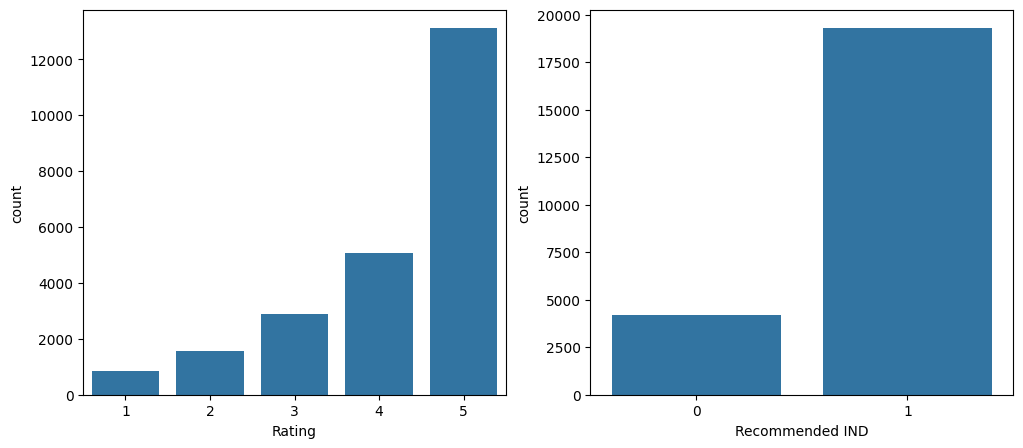

In [7]:
plt.subplots(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(data=data,x='Rating')

plt.subplot(1,2,2)
sns.countplot(data=data,x="Recommended IND")
plt.show()

In [8]:
fig = px.histogram(data, marginal='box',
                   x= "Age", title="Age Group",
                   color="Recommended IND",
                   nbins=65-18,
                   color_discrete_sequence=['green','red'])
fig.update_layout(bargap=0.2)




In [11]:
fig=px.histogram(data,
                 x="Age",marginal='box', title="Age Group",
                 color="Rating",
                 nbins=65-18,
                 color_discrete_sequence=['black','green','blue','red','yellow'])
fig.update_layout(bargap=0.2)

In [12]:
def filter_score(rating):
	return int(rating > 3)

features = ['Class Name', 'Title', 'Review Text']

X = data[features]
y = data['Rating']
y = y.apply(filter_score)



In [13]:
def toLower(data):
	if isinstance(data, float):
		return '<UNK>'
	else:
		return data.lower()

stop_words = stopwords.words("english")

def remove_stopwords(text):
	no_stop = []
	for word in text.split(' '):
		if word not in stop_words:
			no_stop.append(word)
	return " ".join(no_stop)

def remove_punctuation_func(text):
	return re.sub(r'[^a-zA-Z0-9]', ' ', text)

# convert into lower case
X['Title'] = X['Title'].apply(toLower)
X['Review Text'] = X['Review Text'].apply(toLower)
# remove common words
X['Title'] = X['Title'].apply(remove_stopwords)
X['Review Text'] = X['Review Text'].apply(remove_stopwords)
# lemmatization
X['Title'] = X['Title'].apply(lambda x: lemm.lemmatize(x))
X['Review Text'] = X['Review Text'].apply(lambda x: lemm.lemmatize(x))
# remove punctuation
X['Title'] = X['Title'].apply(remove_punctuation_func)
X['Review Text'] = X['Review Text'].apply(remove_punctuation_func)

X['Text'] = list(X['Title']+X['Review Text']+X['Class Name'])

# split into training and testing
X_train, X_test, y_train, y_test = train_test_split(
	X['Text'], y, test_size=0.25, random_state=42)


In [14]:
tokenizer = Tokenizer(num_words=10000,oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)


In [15]:
train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)



In [16]:
train_pad = pad_sequences(train_seq,
                          maxlen=40,
                          truncating="post",
                          padding="post")
test_pad = pad_sequences(test_seq,
                         maxlen=59,
                         truncating="post",
                         padding="post")

In [17]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(10000,128))
model.add(keras.layers.SimpleRNN(64,return_sequences=True))
model.add(keras.layers.SimpleRNN(64))
model.add(keras.layers.Dense(128,activation="relu"))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(1,activation="sigmoid"))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 64)          12352     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1309057 (4.99 MB)
Trainable params: 130905

In [19]:
model.compile("rmsprop","binary_crossentropy",metrics=["accuracy"])
history=model.fit(train_pad,y_train,epochs=5)

Epoch 1/5
551/551 [==============================] - 28s 46ms/step - loss: 0.4220 - accuracy: 0.8215
Epoch 2/5
551/551 [==============================] - 21s 38ms/step - loss: 0.3053 - accuracy: 0.8790
Epoch 3/5
551/551 [==============================] - 24s 43ms/step - loss: 0.2536 - accuracy: 0.9034
Epoch 4/5
551/551 [==============================] - 22s 39ms/step - loss: 0.2008 - accuracy: 0.9256
Epoch 5/5
551/551 [==============================] - 21s 38ms/step - loss: 0.1505 - accuracy: 0.9481


In [20]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(10000,128))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(64,return_sequences=True)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(64)))
model.add(keras.layers.Dense(128,activation="relu"))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(1,activation="sigmoid"))

model.compile("rmsprop", "binary_crossentropy", metrics=["accuracy"])
history = model.fit(train_pad,y_train,epochs=5)

Epoch 1/5
551/551 [==============================] - 76s 123ms/step - loss: 0.3374 - accuracy: 0.8554
Epoch 2/5
551/551 [==============================] - 65s 118ms/step - loss: 0.2575 - accuracy: 0.8975
Epoch 3/5
551/551 [==============================] - 65s 118ms/step - loss: 0.2311 - accuracy: 0.9092
Epoch 4/5
551/551 [==============================] - 63s 115ms/step - loss: 0.2066 - accuracy: 0.9221
Epoch 5/5
551/551 [==============================] - 61s 111ms/step - loss: 0.1820 - accuracy: 0.9339


In [21]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(10000, 128))
model.add(keras.layers.Bidirectional(
	keras.layers.GRU(64, return_sequences=True)))
model.add(keras.layers.Bidirectional(keras.layers.GRU(64)))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile("rmsprop", "binary_crossentropy", metrics=["accuracy"])
history = model.fit(train_pad, y_train, epochs=5)


Epoch 1/5
551/551 [==============================] - 66s 107ms/step - loss: 0.3482 - accuracy: 0.8528
Epoch 2/5
551/551 [==============================] - 57s 104ms/step - loss: 0.2618 - accuracy: 0.8934
Epoch 3/5
551/551 [==============================] - 59s 108ms/step - loss: 0.2335 - accuracy: 0.9073
Epoch 4/5
551/551 [==============================] - 61s 111ms/step - loss: 0.2079 - accuracy: 0.9206
Epoch 5/5
551/551 [==============================] - 61s 110ms/step - loss: 0.1854 - accuracy: 0.9316
